In [1]:
import re
import os
import subprocess
from collections import defaultdict
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm import tqdm

In [2]:
from sklearn.preprocessing import StandardScaler
from Bio import AlignIO

In [3]:
hmm_path = '/nethome/kgeorge/workspace/DomainPrediction/hmm'
data_path = '/nethome/kgeorge/workspace/DomainPrediction/Data'

In [4]:
tm_path = './nethome/kgeorge/workspace/DomainPrediction/src/utils/TMalign'
class TMalign():
    def __init__(self, path) -> None:
        self.tmalign = path

    def run(self, prot_a, prot_b):
        out = subprocess.check_output([self.tmalign, prot_a, prot_b])
        data = str(out).split("\\n")
        for d in data:
            x = re.sub(r"\s\s+", " ", d).split(' ')
            if x[0] == 'Aligned':
                rmsd = float(x[4][:-1])
                seq_id = float(x[6])
            elif x[0] == 'TM-score=':
                tm_score = float(x[1])
                break

        return {
            'rmsd': rmsd,
            'seq_id': seq_id,
            'tm_score': tm_score
        }

In [5]:
class HmmerTools():
    def __init__(self) -> None:
        self.scaler = StandardScaler()

    def hmmalign(self, hmm_path: str, fasta_file: str, 
                  outfile: str | None = None, 
                  trim: bool = False):
        if outfile is None:
            outfile = fasta_file.replace('.fasta', '.stockholm')

        if trim:
            with open(outfile, "w") as fout:
                subprocess.run(['hmmalign', '--trim', hmm_path, fasta_file], stdout=fout)
        else:
            with open(outfile, "w") as fout:
                subprocess.run(['hmmalign', hmm_path, fasta_file], stdout=fout)

        print(f'alignment created: {outfile}')


    def parse_hmmsearch_tblout(self, filename):
        with open(filename) as fin:
            tmp = []
            for line in fin:
                if not line.startswith('#'):
                    tmp.append(line.strip().split()[:7])

        df = pd.DataFrame(tmp, columns=['name', '-', 'domain', 'domain_id', 'Evalue', 'score', 'bias'])
        df['Evalue'] = df['Evalue'].astype(float)
        df['score'] = df['score'].astype(float)
        df['bias'] = df['bias'].astype(float)

        return df

    def sort_by_Eval(self, df, top=None):
        df_tmp = df[['name']].drop_duplicates().sort_values(by=['name']).reset_index(drop=True)
        
        for domain in df['domain'].unique():
            print(f'domain {domain} {df[df["domain"] == domain].shape[0]}')
            df_tmp[domain] = df[df['domain'] == domain].sort_values(by=['name'])['Evalue'].to_numpy()

        df_tmp['sum'] = df_tmp[df['domain'].unique()].sum(axis=1)

        df_tmp['norm_sum'] = self.scaler.fit_transform(df_tmp[df['domain'].unique()]).sum(axis=1)

        df_sorted = df_tmp.sort_values(by=['norm_sum'])
        if top is None:
            return df_sorted['name'].to_numpy()
        else:
            return df_sorted['name'].to_numpy()[:top]
        
    def sort_by_Eval_domain(self, df, domain, top=None):

        df_tmp = df[df['domain'] == domain]
        df_sorted = df_tmp.sort_values(by=['Evalue'])

        if top is None:
            return df_sorted['name'].to_numpy()
        else:
            return df_sorted['name'].to_numpy()[:top]

In [6]:
class AlignTools():
    def __init__(self, path: str) -> None:
        self.align = AlignIO.read(path, "stockholm")
    
    def show_alignment(self):
        print(self.align)

    def get_alignment_length(self):
        return self.align.get_alignment_length()
    
    def get_num_sequences(self):
        return len(self.align)

    def get_pairwise_identity(self):
        pairwise_seqid = np.eye(self.get_num_sequences())

        for i, record_1 in enumerate(self.align):
            for j, record_2 in enumerate(self.align):
                seq_id = 0
                for s1, s2 in zip(record_1.seq, record_2.seq):
                    if s1 != '-' and s2 != '-' and s1 != '.' and s2 != '.' and s1 == s2:
                        seq_id += 1

                pairwise_seqid[i,j] = seq_id/self.get_alignment_length()

        return pairwise_seqid

In [7]:
tmalign = TMalign(tm_path)
hmmer = HmmerTools()

In [8]:
pfam_T_hmm = '/nethome/kgeorge/workspace/DomainPrediction/hmm/PF00550_T.hmm'
fasta_loc = os.path.join(data_path, '/nethome/kgeorge/workspace/DomainPrediction/Data/DCA_experiments/gen_seq.fasta')
hmmer.hmmalign(hmm_path=pfam_T_hmm, fasta_file=fasta_loc, trim=True)

alignment created: /nethome/kgeorge/workspace/DomainPrediction/Data/DCA_experiments/gen_seq.stockholm


In [9]:
align_dca_seq = AlignTools(os.path.join(data_path, '/nethome/kgeorge/workspace/DomainPrediction/Data/DCA_experiments/gen_seq.stockholm'))

In [10]:
align_dca_seq.get_num_sequences()

101

In [11]:
# wrt to original. original at 0 
align_dca_seq.get_pairwise_identity()[0][1:]

array([0.2739726 , 0.30136986, 0.31506849, 0.34246575, 0.28767123,
       0.34246575, 0.31506849, 0.34246575, 0.28767123, 0.24657534,
       0.31506849, 0.2739726 , 0.31506849, 0.26027397, 0.2739726 ,
       0.2739726 , 0.30136986, 0.35616438, 0.32876712, 0.26027397,
       0.26027397, 0.31506849, 0.23287671, 0.23287671, 0.34246575,
       0.21917808, 0.28767123, 0.28767123, 0.32876712, 0.2739726 ,
       0.20547945, 0.2739726 , 0.20547945, 0.31506849, 0.2739726 ,
       0.24657534, 0.28767123, 0.35616438, 0.23287671, 0.30136986,
       0.30136986, 0.23287671, 0.35616438, 0.26027397, 0.32876712,
       0.35616438, 0.24657534, 0.28767123, 0.24657534, 0.23287671,
       0.2739726 , 0.24657534, 0.24657534, 0.2739726 , 0.21917808,
       0.31506849, 0.2739726 , 0.21917808, 0.34246575, 0.30136986,
       0.23287671, 0.23287671, 0.26027397, 0.24657534, 0.28767123,
       0.32876712, 0.2739726 , 0.36986301, 0.24657534, 0.23287671,
       0.32876712, 0.24657534, 0.24657534, 0.26027397, 0.27397

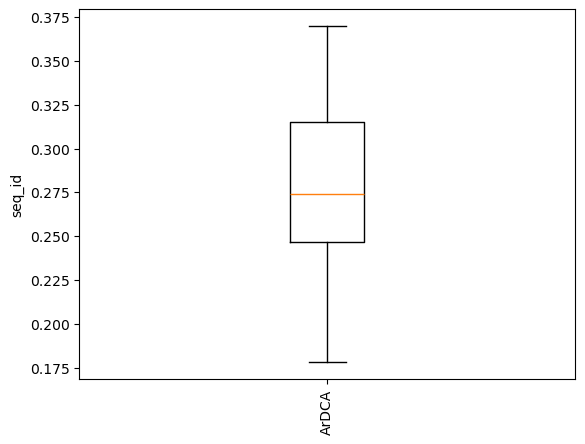

In [12]:
fig, ax = plt.subplots()
_ = ax.boxplot([align_dca_seq.get_pairwise_identity()[0][1:]],
               labels=['ArDCA'])
ax.set_ylabel('seq_id')
ax.tick_params(axis='x', labelrotation=90)

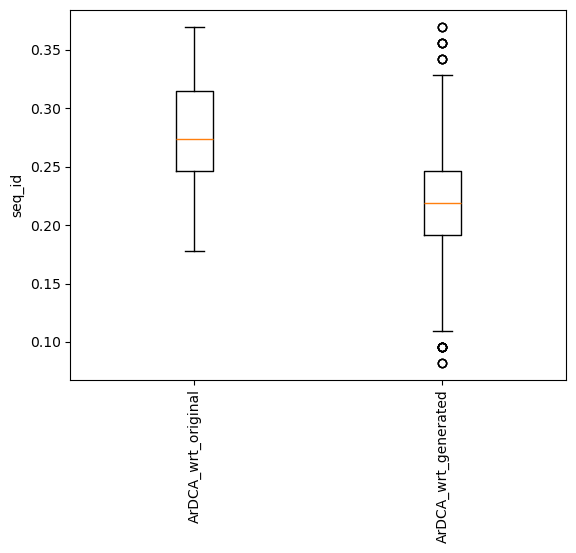

In [13]:
fig, ax = plt.subplots()
_ = ax.boxplot([align_dca_seq.get_pairwise_identity()[0][1:], align_dca_seq.get_pairwise_identity()[1:,1:][np.triu_indices(align_dca_seq.get_num_sequences()-2, k = 1)]],
               labels=['ArDCA_wrt_original', 'ArDCA_wrt_generated'])
ax.set_ylabel('seq_id')
ax.tick_params(axis='x', labelrotation=90)

In [36]:
align_dca_seq.show_alignment()

Alignment with 101 rows and 120 columns
-------------------geieia--LATIWRELLNV-EQ---...--- GxpS_T
----------------tmaaklcpe--------DVLG---PEE-...--- GxpS_T-gen_0
------------------daaaaar-ALAQLWSSDLG--NQQE-...--- GxpS_T-gen_1
-------------kfaaplstlwsq----------LDV-SA-Q-...--- GxpS_T-gen_2
-------------------faaand----NIWSKILGI-NS---...--- GxpS_T-gen_3
-------------------pcaaaa-KLESLWAQLLQV-GSL--...--- GxpS_T-gen_4
-------------------aaaawl----TAISEDLSA-PTLV-...--- GxpS_T-gen_5
-----------------maaaawqg------WSRVLNI-LP-D-...--- GxpS_T-gen_6
-----laaaaiklhdfcrvfkpvnv-------------------...--- GxpS_T-gen_7
--------------akyaaasvriw--------RELGV-RSTR-...--- GxpS_T-gen_8
---eaaaaislaefwaelrlekcma-------------------...--- GxpS_T-gen_9
--------------------caaaa-RIQQIWAEILQL-KDAV-...--- GxpS_T-gen_10
-------------------gaaaae-VLCDIWGEAQGL-D--F-...--- GxpS_T-gen_11
-------------------sakaae-VLQNIWSRLGDH-DCQT-...--- GxpS_T-gen_12
------------------sdaaywl----AKWEDGLGI-EPRD-...--- GxpS_T-gen_13
--

In [37]:
for res in align_dca_seq.align:
    print(res.seq)

-------------------geieia--LATIWRELLNV-EQ---V-G-RHDSFFALGGHSLLAVRMIERLRRI--GLGLSVQTLFQ-HPTLSVLAQ--slvp------------------
----------------tmaaklcpe--------DVLG---PEE-I-G-VNDDFFRLGGDSLLANAVSGLINTAS-NIHISERDIFQ-NSTLSQLAA------------------------
------------------daaaaar-ALAQLWSSDLG--NQQE---G-ASDKFFKLGGDSLSARLIALA-HQA--KHTLPVAQVMQ-YPTVADLAA--ag--------------------
-------------kfaaplstlwsq----------LDV-SA-Q-L-G-IHDNFFQVGGHSVFAIQGVNMLRRH--SLSLTVGEIFE-NPTLFGLVAYI----------------------
-------------------faaand----NIWSKILGI-NS---V-D-RRDNFFSAGGHSLSAMKLIAR-AKIM-GVALKVGEIFE-NGTLQKLARMLa---------------------
-------------------pcaaaa-KLESLWAQLLQV-GSL--I-N-IHDHRDAVGGDSLGADTVVAAVRKN--GAGWSLKDIFE-NRTIKNLAA--s---------------------
-------------------aaaawl----TAISEDLSA-PTLV-----TNDSFFQLGGDSLKAIQLAARARRM--GFQISVSDLFD-KPTLASL----hyaa------------------
-----------------maaaawqg------WSRVLNI-LP-D-V-S-THDDFFDIGGHSL-FILLVAVLRARQ-GIELSIKTVYQ-LPTINRAAA--r---------------------
-----laaaaiklhdfcrvfkpvnv-------